In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

In [13]:
import os
import logging
import community_detection_1.realcommunities_ as rc_
from main import run_community_detection
from urllib.request import urlretrieve
import sys
from collections import defaultdict
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("bio_benchmark.log"),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)
import gzip
from tqdm import tqdm
import json

In [37]:
def download_go_annotations( organism="human"):
        """
        Download GO annotations from UniProt.
        
        Args:
            organism: NCBI taxonomy ID (default: 9606 for human)
        """
        logger.info(f"Downloading GO annotations for organism {organism}")
        
        # Define file paths
        gaf_path = os.path.join("ppi_data/", f"goa_{organism}.gaf.gz")
        output_path = os.path.join("ppi_data/", f"go_annotations_{organism}3.json")
        
        # Download if not exists
        if not os.path.exists(gaf_path):
            if organism == "9606":  # Human
                url = "https://ftp.ebi.ac.uk/pub/databases/GO/goa/HUMAN/goa_human.gaf.gz"
            elif organism == "10090":  # Mouse
                url = "https://ftp.ebi.ac.uk/pub/databases/GO/goa/MOUSE/goa_mouse.gaf.gz"
            elif organism == "10116":  # Rat
                url = "https://ftp.ebi.ac.uk/pub/databases/GO/goa/RAT/goa_rat.gaf.gz"
            else:
                raise ValueError(f"Unsupported organism: {organism}")
            
            logger.info(f"Downloading from {url}")
            
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('content-length', 0))
            
            with open(gaf_path, 'wb') as f:
                with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
                    for data in response.iter_content(chunk_size=1024):
                        f.write(data)
                        pbar.update(len(data))
        
        # Parse annotations if output doesn't exist
        if not os.path.exists(output_path):
            logger.info(f"Parsing GO annotations")
            
            # Initialize dictionaries
            go_to_proteins = defaultdict(set)
            protein_to_go = defaultdict(set)
            go_names = {}
            aspects={}
            with gzip.open(gaf_path, 'rt') as f:
                k=0
                for line in tqdm(f, desc="Parsing annotations"):
                    if line.startswith('!'):
                        continue
                    
                    fields = line.strip().split('\t')
                    if len(fields) < 15:
                        continue
                    if k==0:
                        print(fields)
                    k+=1
                    db, protein_id, _, _, go_id, _, _, _, aspect, term_name = fields[:10]
                    
                    # Skip if not UniProt
                    if db != "UniProtKB":
                        continue
                    
                    # Skip if not molecular function or biological process
                    if aspect not in ['F', 'P']:
                        continue
                    
                    # Get UniProt ID only (without isoform)
                    protein_id = protein_id.split('-')[0]
                    
                    go_to_proteins[go_id].add(protein_id)
                    protein_to_go[protein_id].add(go_id)
                    go_names[go_id] = term_name
                    aspects[go_id]=aspect
            
            # Convert sets to lists for JSON serialization
            go_to_proteins_list = {k: list(v) for k, v in go_to_proteins.items()}
            protein_to_go_list = {k: list(v) for k, v in protein_to_go.items()}
            
            # Save to JSON
            with open(output_path, 'w') as f:
                json.dump({
                    'go_to_proteins': go_to_proteins_list,
                    'protein_to_go': protein_to_go_list,
                    'go_names': go_names,
                    "aspects":aspects
                }, f)
            
            logger.info(f"Annotations saved to {output_path}")
            logger.info(f"Found {len(go_to_proteins)} GO terms and {len(protein_to_go)} proteins")
            
            
        return f"go_{organism}"

In [39]:
download_go_annotations( organism="human")

2025-02-20 11:20:49,151 - __main__ - INFO - Downloading GO annotations for organism human
2025-02-20 11:20:49,153 - __main__ - INFO - Parsing GO annotations


Parsing annotations: 20052it [00:00, 200149.41it/s]

['UniProtKB', 'A0A024RBG1', 'NUDT4B', 'enables', 'GO:0000298', 'GO_REF:0000033', 'IBA', 'PANTHER:PTN000290327|RGD:1310183|SGD:S000005689|UniProtKB:O95989', 'F', 'Diphosphoinositol polyphosphate phosphohydrolase NUDT4B', 'NUDT4B', 'protein', 'taxon:9606', '20231108', 'GO_Central']


Parsing annotations: 672280it [00:03, 199535.34it/s]


2025-02-20 11:20:53,854 - __main__ - INFO - Annotations saved to ppi_data/go_annotations_human3.json
2025-02-20 11:20:53,854 - __main__ - INFO - Found 16749 GO terms and 19097 proteins


'go_human'

In [9]:
download_go_annotations( organism="yeast")

2025-02-17 20:56:21,163 - __main__ - INFO - Downloading GO annotations for organism yeast
2025-02-17 20:56:21,165 - __main__ - INFO - Parsing GO annotations


Parsing annotations: 109937it [00:00, 168888.82it/s]


2025-02-17 20:56:22,202 - __main__ - INFO - Annotations saved to ppi_data/go_annotations_yeast.json
2025-02-17 20:56:22,204 - __main__ - INFO - Found 5078 GO terms and 6060 proteins


'go_yeast'

In [19]:
import os
import sys
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import requests
import gzip
import shutil
import json
from tqdm import tqdm
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
import random
from itertools import combinations
from collections import defaultdict
import logging
import community_detection_1.realcommunities_ as rc_
from main import run_community_detection
from urllib.request import urlretrieve
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("bio_benchmark.log"),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

In [20]:
import json
def load_annotation_data(file_path):
    with open(file_path, "r") as file:
	    annotation_data = json.load(file)
    return annotation_data


In [145]:
algorithms=["big_s2","blue_genes","csbio_iitm_hamming","dcut","fast_greedy","label_propagation","louvain","luminy_multiplex","MLRMCL","nextmr","shared_neighbor","SpecHier","spectral_clustering","spin_glass","SVT","teamCS","triple_ahc","tuskdmi","walktrap","zhenhua"]
algorithms1=["Big-S2","blue_genes","csbio_iitm_hamming","Dcut","Fast greedy","Label propagation","Louvain","Luminy_Multiplex","MLRMCL","Nextmr","Shared neighbor","SpecHier","Spectral_clustering","Spin glass","SVT","teamCS","TripleAHC","Tuskdmi","walktrap","zhenhua"]

In [25]:
def parse_community_file(filename):
    communities = []
    with open(filename, 'r') as file:
        for line in file:
            # Skip time info line if present
            if line.startswith("Time:"):
                continue
            
            # Extract cluster information
            if line.startswith("Cluster"):
                # Extract the numbers between square brackets
                start_idx = line.find('[')
                end_idx = line.find(']')
                
                if start_idx != -1 and end_idx != -1:
                    # Extract the string containing numbers
                    numbers_str = line[start_idx+1:end_idx]
                    
                    # Split by comma and convert to integers
                    numbers = [int(num.strip()) for num in numbers_str.split(',')]
                    communities.append(numbers)
    
    return communities

In [41]:
import json
import pandas as pd
def perform_enrichment_analysis(organism,min_go_size=5,max_go_size=500):
    annotation_data=load_annotation_data(f"ppi_data/go_annotations_{organism}.json")
    go_to_proteins = annotation_data['go_to_proteins']
    protein_to_go = annotation_data['protein_to_go']
    go_names = annotation_data['go_names']
    mapping=pd.read_excel(f"ppi_data/{organism}_mapping_proper.xlsx")
    dict_mapping=mapping.to_dict()["Entry"]
    network_proteins = set(list(mapping["id"]))
    network_proteins_mapped=list(mapping["Entry"])
    # Filter GO terms by size
    filtered_go_terms = {
            go_id: proteins for go_id, proteins in go_to_proteins.items()
            if min_go_size <= len(set(proteins).intersection(network_proteins_mapped)) <= max_go_size
        }
        
    logger.info(f"Using {len(filtered_go_terms)} GO terms after filtering by size")
        
    # Initialize results dictionary
    enrichment_results={}

    for algo in algorithms:
        logger.info(f"Performing enrichment analysis for {algo}")
        algo_results = []
        community_file=f"ppi_data/{organism}_results/{algo}.txt"
        communities=parse_community_file(community_file)
        for i, community in enumerate(communities):
                community_proteins=[dict_mapping[j] for j in community]

                if len(community_proteins) < 3:
                    continue
                
                # Calculate enrichment for each GO term
                for go_id, go_proteins in filtered_go_terms.items():
                    
                    go_proteins_in_network = set(go_proteins).intersection(network_proteins_mapped)
                    
                    # Contingency table
                    # a: proteins in both community and GO term
                    a = len(set(community_proteins).intersection(go_proteins_in_network))
                    
                    # Skip if no overlap
                    if a == 0:
                        continue
                    
                    # b: proteins in community but not in GO term
                    b = len(community_proteins) - a
                    
                    # c: proteins in GO term but not in community
                    c = len(go_proteins_in_network) - a
                    
                    # d: proteins in neither community nor GO term
                    d = len(network_proteins) - a - b - c
                    
                    # Calculate fold enrichment
                    observed = a
                    expected = (a + b) * (a + c) / (a + b + c + d)
                    fold_enrichment = observed / expected if expected > 0 else float('inf')
                    
                    # Calculate p-value using hypergeometric test
                    # M: total population (network proteins)
                    # n: successes in population (proteins in GO term)
                    # N: sample size (proteins in community)
                    # k: successes in sample (overlap)
                    M = len(network_proteins)
                    n = len(go_proteins_in_network)
                    N = len(community_proteins)
                    k = a
                    
                    # P-value is the probability of getting k or more successes
                    p_value = hypergeom.sf(k-1, M, n, N)
                    
                    algo_results.append({
                        'community_id': i,
                        'community_size': len(community_proteins),
                        'go_id': go_id,
                        'go_name': go_names.get(go_id, "Unknown"),
                        'go_size': len(go_proteins_in_network),
                        'overlap': a,
                        'fold_enrichment': fold_enrichment,
                        'p_value': p_value
                    })
            
            # Convert to DataFrame
        df = pd.DataFrame(algo_results)
        print(df.head())
        # Apply multiple testing correction
        if not df.empty:
                df['adjusted_p_value'] = multipletests(df['p_value'], method='fdr_bh')[1]
                
                # Filter by adjusted p-value
                df_significant = df[df['adjusted_p_value'] < 0.05].copy()
                
                # Sort by fold enrichment
                df_significant.sort_values('fold_enrichment', ascending=False, inplace=True)
                
                # Save results
                
                output_file = os.path.join(f"ppi_data/{organism}_results/", f"{algo}_enrichment.csv")
                df_significant.to_csv(output_file, index=False)
                
                logger.info(f"Found {len(df_significant)} significant enrichments for {algo}")


    
    


In [43]:
perform_enrichment_analysis("yeast")

2025-02-19 20:45:41,488 - __main__ - INFO - Using 1476 GO terms after filtering by size
2025-02-19 20:45:41,488 - __main__ - INFO - Performing enrichment analysis for big_s2
   community_id  community_size       go_id  \
0             0             141  GO:0003677   
1             0             141  GO:0003723   
2             0             141  GO:0004190   
3             0             141  GO:0006310   
4             0             141  GO:0006508   

                                  go_name  go_size  overlap  fold_enrichment  \
0  Transposon Ty1-NL2 Gag-Pol polyprotein      175        1         0.234691   
1          Cytochrome b mRNA maturase bI3      269        5         0.763400   
2  Transposon Ty1-NL2 Gag-Pol polyprotein        7        1         5.867275   
3  Transposon Ty1-NL2 Gag-Pol polyprotein       25        1         1.642837   
4  Transposon Ty1-NL2 Gag-Pol polyprotein       54        2         1.521145   

    p_value  
0  0.987483  
1  0.791864  
2  0.158557  
3  0.4

In [162]:
def visualize_no_enrichments(organism,key=5):
        go_counts = []
        k=0
        for algo in algorithms:
            df=pd.read_csv(f"ppi_data/{organism}_results/{algo}_enrichment.csv")
            algo1=algorithms1[k]
            k+=1
            go_counts.append({
                'Algorithm': algo1,
                'Significant_terms': len(df)
            })
        
        go_counts_df = pd.DataFrame(go_counts)
        go_counts_df=go_counts_df.sort_values(by="Significant_terms",ascending=False)
        plt.figure(figsize=(12, 6))
        sns.barplot(data=go_counts_df, x='Algorithm', y='Significant_terms',palette="viridis")
        plt.title(f'Number of Significantly Enriched GO Terms on {organism} ppi network')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(f"ppi_data/{organism}_results/Figures/", f'Fig{key}.png'), dpi=300)
        

        plt.savefig(os.path.join(f"ppi_data/{organism}_results/Figures/" f'Fig{key}.tiff'), format='tiff',dpi=300)
        plt.show()
        plt.close()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11748\1874170549.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=go_counts_df, x='Algorithm', y='Significant_terms',palette="viridis")


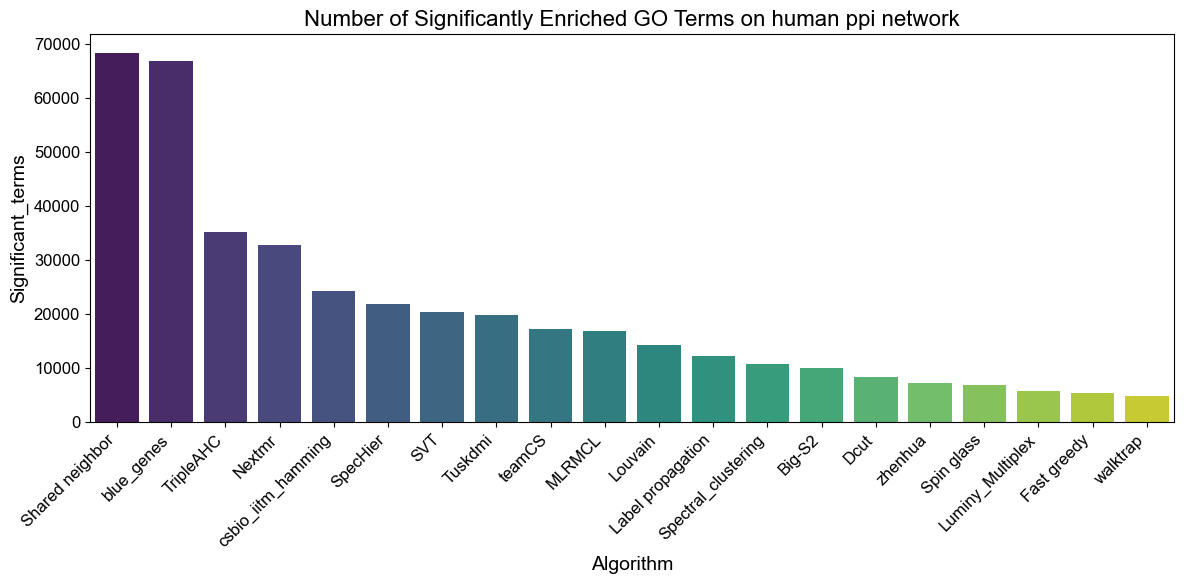

C:\Users\Admin\AppData\Local\Temp\ipykernel_11748\1874170549.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=go_counts_df, x='Algorithm', y='Significant_terms',palette="viridis")


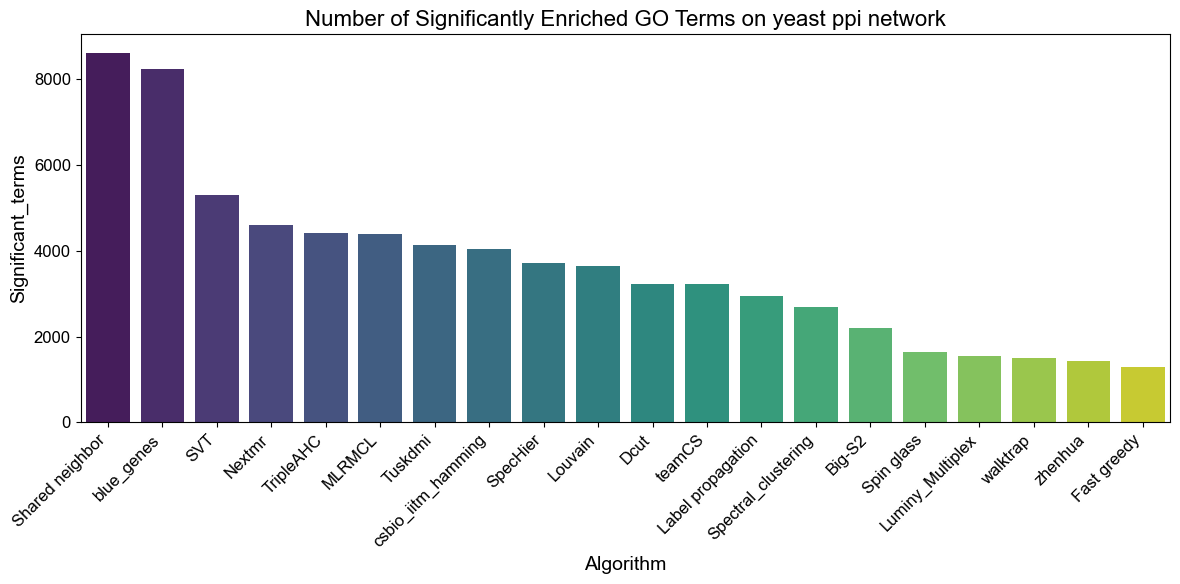

In [163]:
visualize_no_enrichments("human",5)
visualize_no_enrichments("yeast",6)

In [165]:
def summarize_results(organism,key):
        summary_data = []
        json_data=load_annotation_data(f"ppi_data/go_annotations_{organism}3.json")
        aspects=json_data["aspects"]
        k=0
        for algo in algorithms:
            algo1=algorithms1[k]
            k+=1
            communities=parse_community_file(f"ppi_data/{organism}_results/{algo}.txt")
            enrichment_df = pd.read_csv(f"ppi_data/{organism}_results/{algo}_enrichment.csv")
            aspects_col=[aspects[go_id] for go_id in enrichment_df["go_id"]]
            #print(set(aspects_col))
            enrichment_df["function"]=aspects_col
            enrichment_df_F=enrichment_df[enrichment_df["function"]=="F"]
            #print(len(enrichment_df_F))
            enrichment_df_P=enrichment_df[enrichment_df["function"]=="P"]
            statistic, combined_p_value = combine_pvalues(enrichment_df["adjusted_p_value"], method='fisher')
            summary_data.append({
                'Algorithm': algo1,
                'num_communities': len(communities),
                'avg_community_size': np.mean([len(c) for c in communities]),
                'significant_terms': len(enrichment_df),
                'max_fold_enrichment_mol_fun': enrichment_df_F['fold_enrichment'].max() if not enrichment_df_F.empty else 0,
                'avg_fold_enrichment_mol_fun': enrichment_df_F['fold_enrichment'].mean() if not enrichment_df_F.empty else 0,
                'max_fold_enrichment_bio_proc': enrichment_df_P['fold_enrichment'].max() if not enrichment_df_P.empty else 0,
                'avg_fold_enrichment_bio_proc': enrichment_df_P['fold_enrichment'].mean() if not enrichment_df_P.empty else 0,
                'Avg_fold_enrichment': enrichment_df['fold_enrichment'].mean(),
                'Min_fold_enrichment': enrichment_df['fold_enrichment'].min(),
                'Max_fold_enrichment': enrichment_df['fold_enrichment'].max(),
                
                

            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df=summary_df.sort_values(by='Avg_fold_enrichment',ascending=False)
        plt.figure(figsize=(12, 6))
        sns.barplot(data=summary_df, x='Algorithm', y='Avg_fold_enrichment',palette="viridis")
        plt.title(f'Avg fold enrichment in {organism} ppi network')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(f"ppi_data/{organism}_results/Figures/", f'Fig{key}.png'), dpi=300)
        plt.savefig(os.path.join(f"ppi_data/{organism}_results/Figures/" f'Fig{key}.tiff'), format='tiff',dpi=300)
        plt.show()
        plt.close()
        summary_df.to_csv(os.path.join(f"ppi_data/{organism}_results/Figures/", 'algorithm_summary1.csv'), index=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_11748\1498607352.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Algorithm', y='Avg_fold_enrichment',palette="viridis")


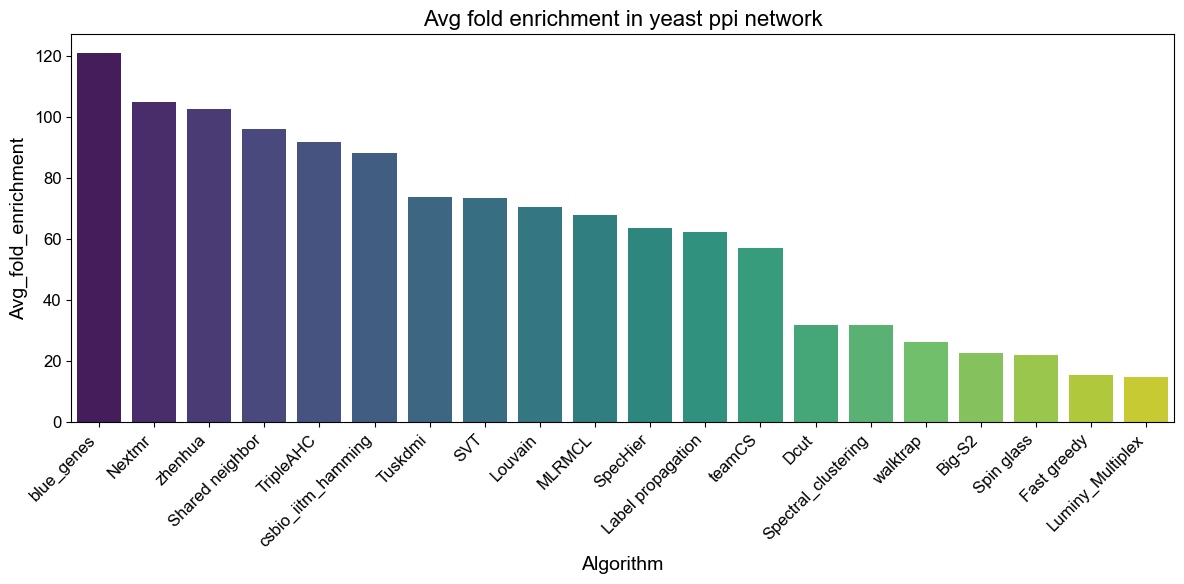

C:\Users\Admin\AppData\Local\Temp\ipykernel_11748\1498607352.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Algorithm', y='Avg_fold_enrichment',palette="viridis")


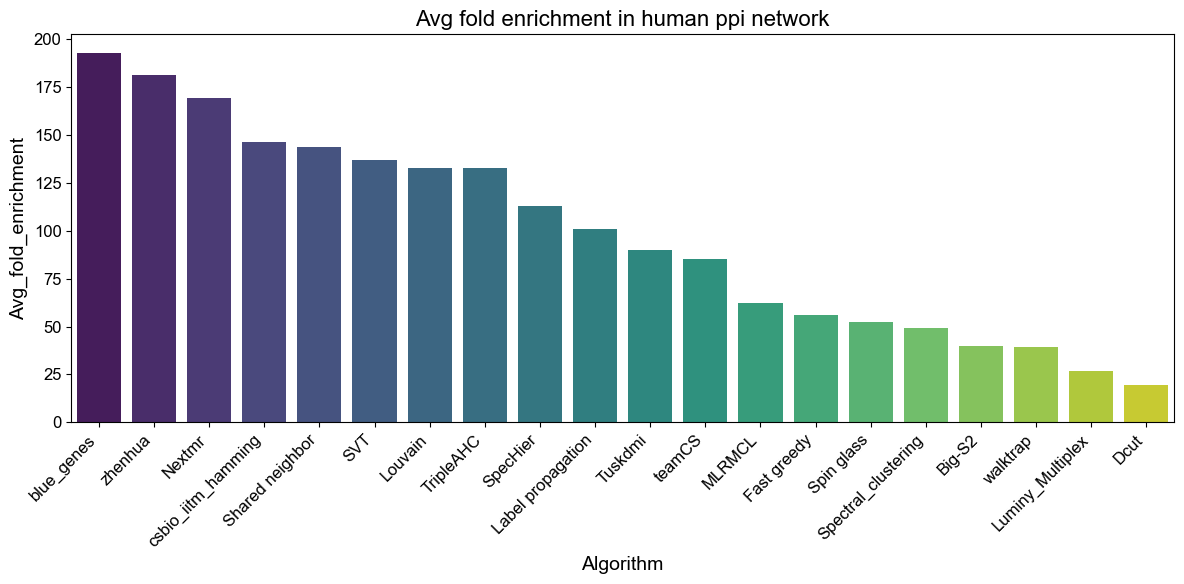

In [166]:
summarize_results("yeast",10)
summarize_results("human",9)

In [167]:
def visualise_community_sizes(organism,key):
        community_sizes = []
        k=0
        for algo in algorithms:
            algo1=algorithms1[k]
            k+=1
            communities=parse_community_file(f"ppi_data/{organism}_results/{algo}.txt")
            for community in communities:
                community_sizes.append({
                    'Algorithm': algo1,
                    'Size': len(community)
                })
        community_size_df = pd.DataFrame(community_sizes)
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=community_size_df, x='Algorithm', y='Size',palette="viridis",showfliers=False)
        Organism="Human" if organism=="human" else "Yeast"
        plt.title(f'Community Size Distribution Across Algorithms on the {Organism} PPI Network')
        plt.xticks(rotation=45, ha='right')
        plt.yscale('log')
        plt.tight_layout()
        plt.savefig(os.path.join(f"ppi_data/{organism}_results/Figures/", f'Fig{key}.png'), dpi=300)
        plt.savefig(os.path.join(f"ppi_data/{organism}_results/Figures/" f'Fig{key}.tiff'), format='tiff',dpi=300)
        plt.show()
        plt.close()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11748\1556022630.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=community_size_df, x='Algorithm', y='Size',palette="viridis",showfliers=False)


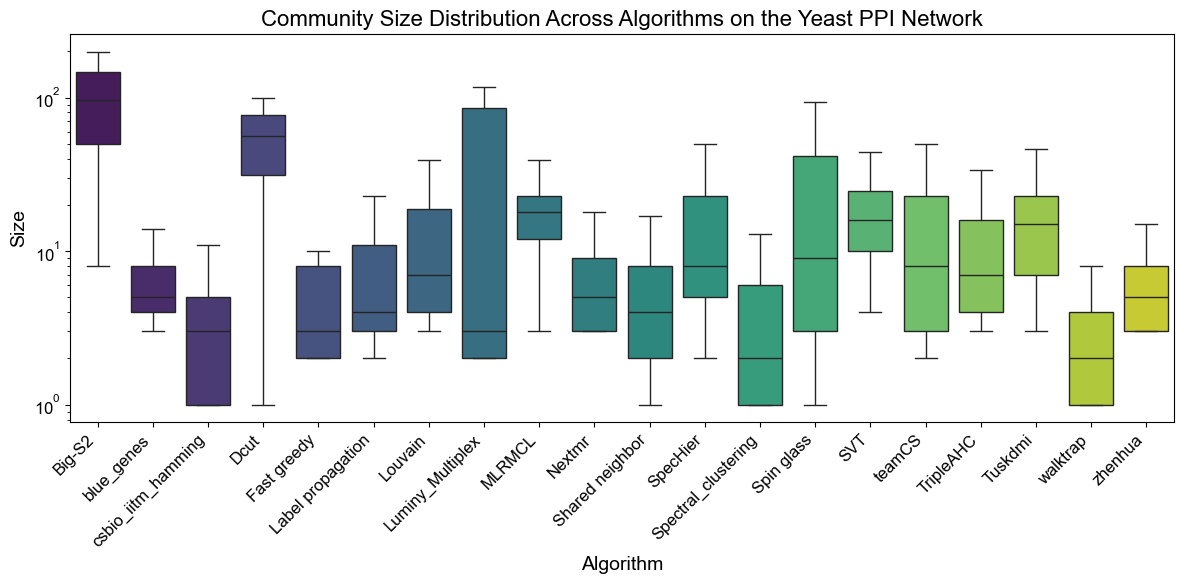

C:\Users\Admin\AppData\Local\Temp\ipykernel_11748\1556022630.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=community_size_df, x='Algorithm', y='Size',palette="viridis",showfliers=False)


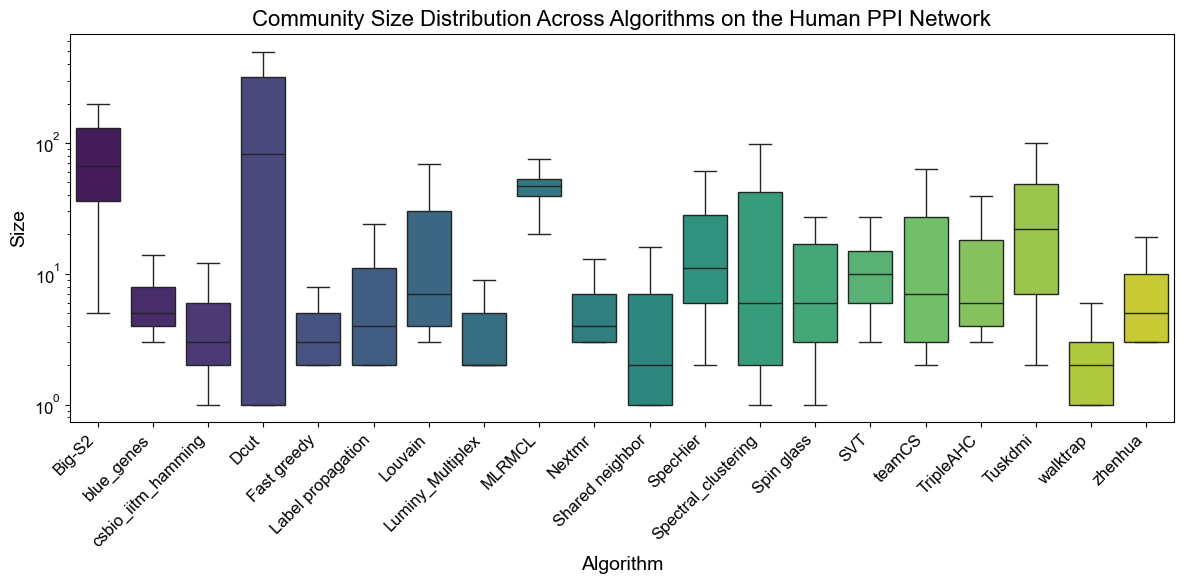

In [168]:
visualise_community_sizes("yeast",key=8)
visualise_community_sizes("human",key=7)

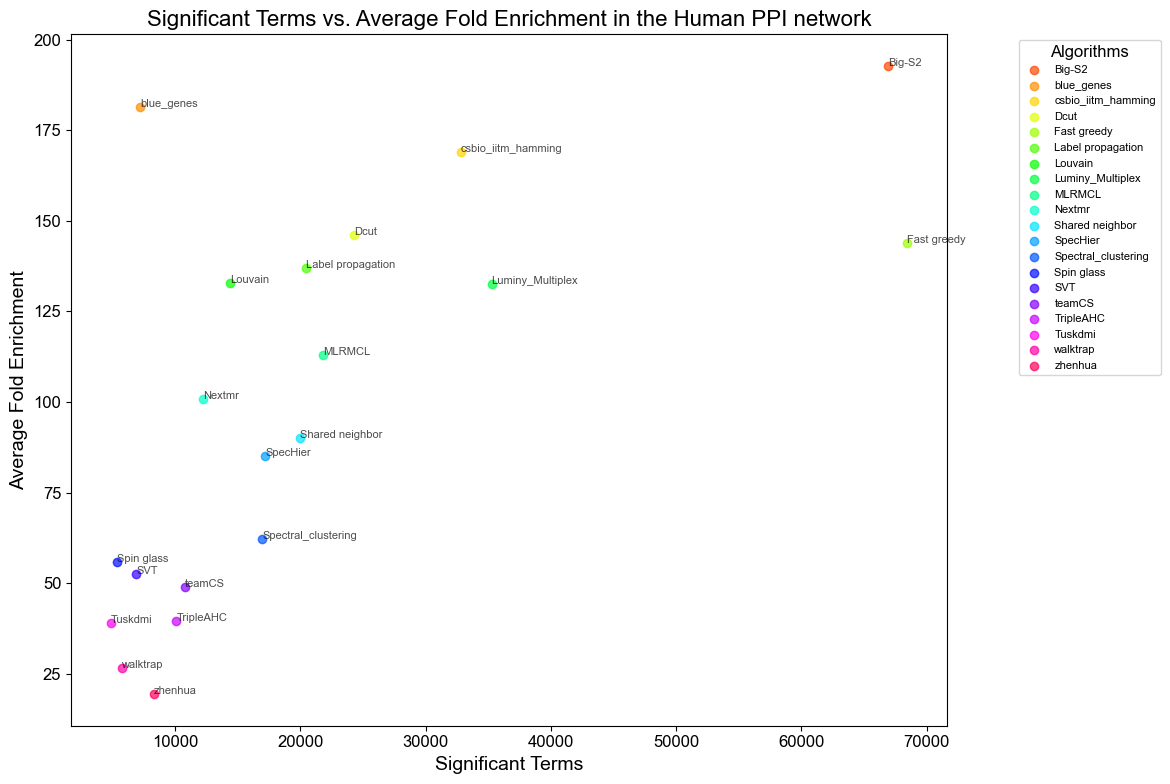

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv("ppi_data/human_results/Figures/algorithm_summary1.csv")
data["Algorithm"]=algorithms1
# Assign unique colors to each algorithm using Seaborn's color palette
unique_algorithms = data['Algorithm'].unique()
palette = sns.color_palette("hsv", len(unique_algorithms))
color_map = {alg: palette[i] for i, alg in enumerate(unique_algorithms)}

# Scatter plot with colors based on algorithm
plt.figure(figsize=(12, 8))
for i, row in data.iterrows():
    plt.scatter(row['significant_terms'], row['Avg_fold_enrichment'], 
                color=color_map[row['Algorithm']], label=row['Algorithm'] if row['Algorithm'] not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.7)

# Add annotations (node names)
for i, txt in enumerate(data['Algorithm']):
    plt.annotate(txt, (data['significant_terms'][i], data['Avg_fold_enrichment'][i]), fontsize=8, alpha=0.7)

# Set titles and labels
plt.title('Significant Terms vs. Average Fold Enrichment in the Human PPI network')
plt.xlabel('Significant Terms')
plt.ylabel('Average Fold Enrichment')

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), title="Algorithms", fontsize=8)
plt.savefig(os.path.join(f"ppi_data/human_results/Figures/" f'S6_Fig.tiff'), format='tiff',dpi=300)
plt.tight_layout()
plt.show()


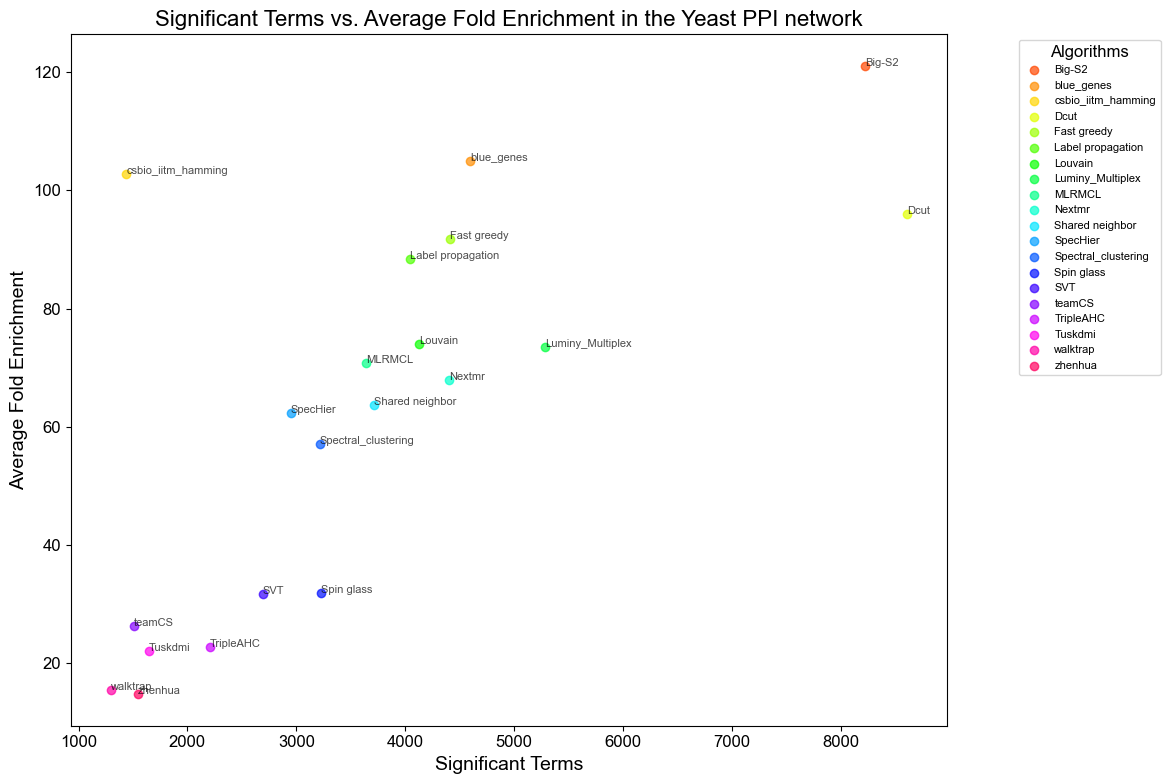

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv("ppi_data/yeast_results/Figures/algorithm_summary1.csv")
data["Algorithm"]=algorithms1
# Assign unique colors to each algorithm using Seaborn's color palette
unique_algorithms = data['Algorithm'].unique()
palette = sns.color_palette("hsv", len(unique_algorithms))
color_map = {alg: palette[i] for i, alg in enumerate(unique_algorithms)}

# Scatter plot with colors based on algorithm
plt.figure(figsize=(12, 8))
for i, row in data.iterrows():
    plt.scatter(row['significant_terms'], row['Avg_fold_enrichment'], 
                color=color_map[row['Algorithm']], label=row['Algorithm'] if row['Algorithm'] not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.7)

# Add annotations (node names)
for i, txt in enumerate(data['Algorithm']):
    plt.annotate(txt, (data['significant_terms'][i], data['Avg_fold_enrichment'][i]), fontsize=8, alpha=0.7)

# Set titles and labels
plt.title('Significant Terms vs. Average Fold Enrichment in the Yeast PPI network')
plt.xlabel('Significant Terms')
plt.ylabel('Average Fold Enrichment')

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), title="Algorithms", fontsize=8)
plt.savefig(os.path.join(f"ppi_data/human_results/Figures/" f'S7_Fig.tiff'), format='tiff',dpi=300)
plt.tight_layout()
plt.show()
